# Multi-Asset Portfolio Optimization and Out-of-Sample Portfolio Evaluation (2015–2025)

## Based on well diversified portfolio construction and optimization problems from Dr. Rajnish Mehra's course on Financial Economics.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import cvxpy as cp
import yfinance as yf

In [243]:
# portfolio of well diversied portflios - expanded to 29 assets across many sectors
tickers = ['VTI', 'SPY', 'QQQ', 'IWM', 'VEU', 'EFA', 'EEM', 'EWJ', 'EWZ',
           'XLF', 'XLK', 'XLE', 'XLV', 'XLU', 'XLY', 'XLI', 'XLB',
           'BND', 'TLT', 'LQD', 'SHY', 'IEF', 'GLD', 'DBC', 'VNQ',
           'TIP', 'SCHP', 'USMV', 'MTUM']

start = '2015-01-01'
end = '2023-12-31'

In [194]:
# https://github.com/ranaroussi/yfinance/issues/2422
# fixes yfinance rate limits by adding headers
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('...', session=session)

# monthly values (over daily) will be more stable for this case (compared and researched)
df = yf.download(tickers, start=start, end=end, interval='1mo', auto_adjust=False)['Adj Close']

[*********************100%***********************]  29 of 29 completed


In [223]:
monthly_returns = df.pct_change().dropna()
# annualized
mu = (1 + monthly_returns).prod()**(12 / len(monthly_returns)) - 1 # geometric
# mu = monthly_returns.mean() * 12 # might be better suited for shorter time periods

cov_matrix = monthly_returns.cov()
# annualized
sigma = cov_matrix * 12

In [224]:
def frontier(mu, sigma, short=False, short_limit=None, simulations=100):
    n = len(mu)
    mu = mu.values # mu was a dataframe
    # weighted averages will lie in this range - however with shorting this is not always the case
    target_returns = np.linspace(mu.min(), mu.max(), simulations)
    results = []

    for r in target_returns:
        weights = cp.Variable(n)
        # calculates total variance of this portfolio
        risk_v = cp.quad_form(weights, sigma)
        obj = cp.Minimize(risk_v)
        constraints = [
            cp.sum(weights) == 1,
            mu @ weights == r
        ]
        if not short:
            constraints.append(weights >= 0)
        elif short_limit is not None:
            constraints.append(weights >= -short_limit)
        
        problem = cp.Problem(obj, constraints)
        problem.solve()

        if weights.value is not None:
            std = np.sqrt(risk_v.value)
            results.append((r, std, weights.value))
        else:
            print("weights not found")

    returns, risk, weights_list = zip(*results)
    return np.array(returns), np.array(risk), weights_list

In [197]:
# returns_s - array of returns of 100 constructed portfolios without shorting constraints
returns_s, risk_s, _ = frontier(mu, sigma, short=True)
returns_ns, risk_ns, _ = frontier(mu, sigma, short=False)
returns_sl, risk_sl, _ = frontier(mu, sigma, short=True, short_limit=0.3)

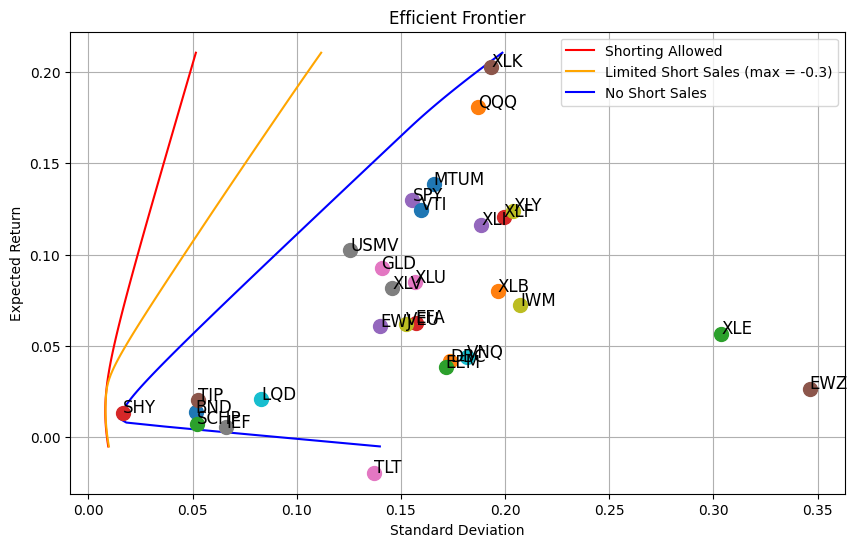

In [261]:
# Plot portfolio
plt.figure(figsize=(10, 6))
plt.plot(risk_s, returns_s, label='Shorting Allowed', color='red')
plt.plot(risk_sl, returns_sl, label='Limited Short Sales (max = -0.3)', color='orange')
plt.plot(risk_ns, returns_ns, label='No Short Sales', color='blue')

# plot individual assets
for i, ticker in enumerate(mu.index):
    plt.plot(np.sqrt(sigma.iloc[i, i]), mu.iloc[i], 'o', markersize=10)
    plt.text(np.sqrt(sigma.iloc[i, i]), mu.iloc[i], ticker, fontsize=12)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

In [260]:
# Theory - for a given expected return, the unconstrained allocations have a lower standard deviation than the constrained allocations.

random_portfolio = np.random.randint(100)

weights_ns = frontier(mu, sigma, short=False)[2][target_index]
weights_s = frontier(mu, sigma, short=True)[2][target_index]

# round down for clarity
weights_ns = np.round(weights_ns, 4)
weights_s = np.round(weights_s, 4)

# portfolio variance (weights.T @ sigma @ weights)
risk_ns_random_port = np.sqrt(weights_ns.T @ sigma @ weights_ns)
risk_s_random_port = np.sqrt(weights_s.T @ sigma @ weights_s)

# allocs_df = pd.DataFrame({
#     'Asset': tickers,
#     'Constrained Weights': weights_ns,
#     'Unconstrained Weights': weights_s
# })

print("Std Dev (Constrained):", risk_c_target)
print("Std Dev (Unconstrained):", risk_uc_target)
# print()
# allocs_df

Std Dev (Constrained): 0.10048823790281351
Std Dev (Unconstrained): 0.06980399203776826


## Introducing a risk free asset (T-bills - assumed risk free)

In [238]:
# 1-month T-bill rates
tbill_data = yf.download("^IRX", start="2015-01-01", end="2023-12-31", interval="1mo")['Close']
# drop first month to align with assets
tbill_data = tbill_data.iloc[1:]

rf_monthly = (tbill_data / 100) / 12
rf_monthly_mean = rf_monthly.mean()
rf_annual = (1 + rf_monthly_mean)**12 - 1

rf_annual = rf_annual.values[0]

[*********************100%***********************]  1 of 1 completed


## 15% std. dev. capped optimized portfolios
- (a) without shorting
- (b) with shorting (limitless)
- (c) -30% shorting limit

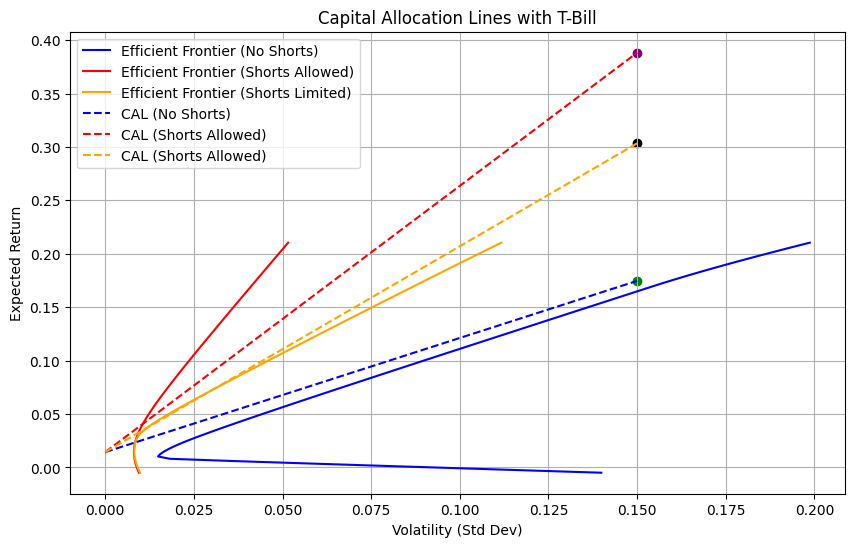

In [245]:
# Find tangency (max Sharpe) portfolio
def max_sharpe(mu, sigma, rf, allow_short=False, short_limit=None):
    n = len(mu)
    mu = mu.values
    w = cp.Variable(n)
    excess_ret = mu - rf
    objective = cp.Maximize(excess_ret @ w)
    constraints = [cp.sum(w) == 1] + ([w >= 0] if not allow_short else [])
    if short_limit is not None:
            constraints.append(w >= -short_limit)
    ## i was missing the exponent - we want to set volatility to 15% cap not variance
    prob = cp.Problem(objective, [cp.quad_form(w, sigma) <= 0.15 ** 2] + constraints)
    prob.solve()
    weights = w.value
    port_ret = mu @ weights
    port_std = np.sqrt(weights.T @ sigma @ weights)
    return port_ret, port_std, weights

# CAL for constrained and unconstrained
returns_cal_ns, risk_cal_ns, weight_cal_ns = max_sharpe(mu, sigma, rf_annual, allow_short=False)
returns_cal_s, risk_cal_s, weight_cal_s = max_sharpe(mu, sigma, rf_annual, allow_short=True)
returns_cal_sl, risk_cal_sl, weight_cal_sl = max_sharpe(mu, sigma, rf_annual, allow_short=True, short_limit=0.3)

# Plot CALs
plt.figure(figsize=(10, 6))
plt.plot(risk_ns, returns_ns, label='Efficient Frontier (No Shorts)', color='blue')
plt.plot(risk_s, returns_s, label='Efficient Frontier (Shorts Allowed)', color='red')
plt.plot(risk_sl, returns_sl, label='Efficient Frontier (Shorts Limited)', color='orange')
plt.plot([0, risk_cal_ns], [rf_annual, returns_cal_ns], label='CAL (No Shorts)', linestyle='--', color='blue')
plt.plot([0, risk_cal_s], [rf_annual, returns_cal_s], label='CAL (Shorts Allowed)', linestyle='--', color='red')
plt.plot([0, risk_cal_sl], [rf_annual, returns_cal_sl], label='CAL (Shorts Allowed)', linestyle='--', color='orange')
plt.scatter(risk_cal_ns, returns_cal_ns, color='green', marker='o')
plt.scatter(risk_cal_s, returns_cal_s, color='purple', marker='o')
plt.scatter(risk_cal_sl, returns_cal_sl, color='black', marker='o')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Capital Allocation Lines with T-Bill')
plt.legend()
plt.grid(True)
plt.show()


In [262]:
stats_data = {
    "Case": ["No Shorting", "Shorting Allowed", "Shorting Limited (30%)"],
    "Expected Return": [f'{returns_cal_ns*100:.2f}%', f'{returns_cal_s*100:.2f}%', f'{returns_cal_sl*100:.2f}%'],
    "Volatility": [risk_cal_ns, risk_cal_s, risk_cal_sl],
    "Sharpe Ratio": [(returns_cal_ns - rf_annual)/risk_cal_ns, 
                    (returns_cal_s - rf_annual)/risk_cal_s,
                    (returns_cal_sl - rf_annual)/risk_cal_sl]
}

# Add weights for each asset
for i in range(len(mu)):
    stats_data[f"Asset {i+1} Weight"] = [
        weight_cal_ns[i], 
        weight_cal_s[i], 
        weight_cal_sl[i]
    ]

stats_df = pd.DataFrame(stats_data)

print("Optimal Portfolio Statistics:")
display(stats_df)

Optimal Portfolio Statistics:


,Case,Expected Return,Volatility,Sharpe Ratio,Asset 1 Weight,Asset 2 Weight,Asset 3 Weight,Asset 4 Weight,Asset 5 Weight,Asset 6 Weight,...,Asset 20 Weight,Asset 21 Weight,Asset 22 Weight,Asset 23 Weight,Asset 24 Weight,Asset 25 Weight,Asset 26 Weight,Asset 27 Weight,Asset 28 Weight,Asset 29 Weight
0,No Shorting,17.46%,0.15,1.068231,2.853168e-10,3.488131e-10,3.758904e-10,4.309009e-10,3.996554e-10,3.531136e-10,...,3.553620e-10,9.017325e-10,5.333395e-10,3.664634e-10,9.067684e-10,8.608748e-10,0.744941,1.275573e-09,6.526100e-10,7.433799e-10
1,Shorting Allowed,38.82%,0.15,2.492092,4.295880e+00,1.352891e-01,2.987500e-01,7.465246e-01,-2.052613e-01,-5.310434e-02,...,-1.667333e-01,3.790608e+00,-1.223227e-01,2.908408e-02,8.656383e-01,1.960705e-01,0.786196,1.333053e-01,1.915424e-03,1.773195e-01
2,Shorting Limited (30%),30.34%,0.15,1.926623,1.008268e+00,-2.119103e-03,-1.273152e-01,-3.000000e-01,-2.036061e-02,-7.136562e-02,...,-3.000000e-01,-3.000000e-01,-3.000000e-01,-3.964125e-03,8.283595e-01,5.643055e-02,0.831514,1.030493e-01,-3.305710e-02,-1.890853e-01


## Out of Sample Testing (2024 - Today)

In [231]:
end = pd.Timestamp.today().strftime('%Y-%m-%d')

df = yf.download(tickers, start=start, end=end, interval='1mo', auto_adjust=False)['Adj Close']
returns = df.pct_change().dropna()
returns_train = returns[returns.index < '2024-01-01']
returns_test = returns[returns.index >= '2024-01-01']

[*********************100%***********************]  29 of 29 completed


In [274]:
mu_train = returns_train.mean() * 12
sigma_train = returns_train.cov() * 12

# allowing shorting had better returns and higher volatility at the same sharpe ratio
ret_train, std_train, weights_train = max_sharpe(mu_train, sigma_train, rf_annual, allow_short=False)

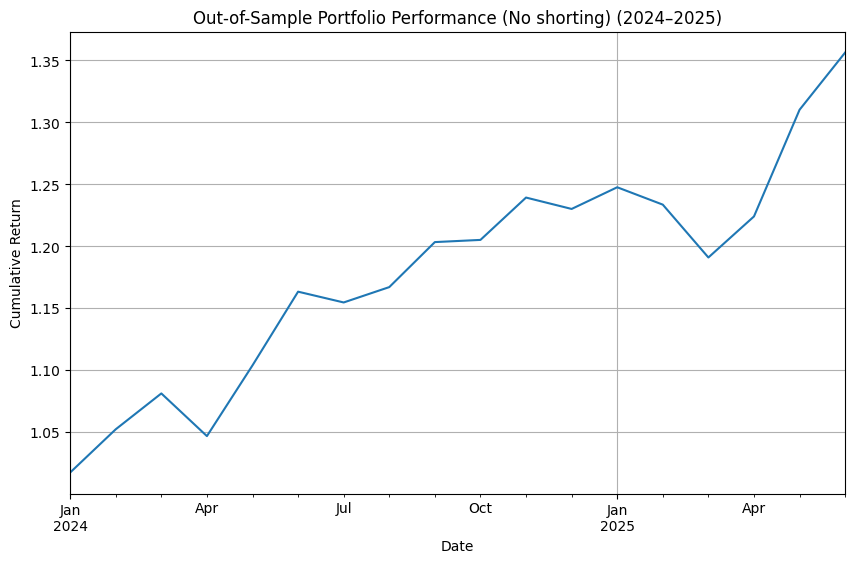

Out-of-Sample Expected Return: 20.96%
Out-of-Sample Volatility: 9.99%
Out-of-Sample Sharpe Ratio: 1.95


In [275]:
# weights applied to out-of-sample data
portfolio_returns_test = returns_test @ weights_train
cumulative_returns = (1 + portfolio_returns_test).cumprod()

# Performance metrics
test_volatility = portfolio_returns_test.std() * np.sqrt(12)
test_return = portfolio_returns_test.mean() * 12
test_sharpe = (test_return - rf_annual) / test_volatility

# Plot
plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title("Out-of-Sample Portfolio Performance (No shorting) (2024–2025)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

print(f"Out-of-Sample Expected Return: {test_return:.2%}")
print(f"Out-of-Sample Volatility: {test_volatility:.2%}")
print(f"Out-of-Sample Sharpe Ratio: {test_sharpe:.2f}")

<Figure size 1400x700 with 0 Axes>

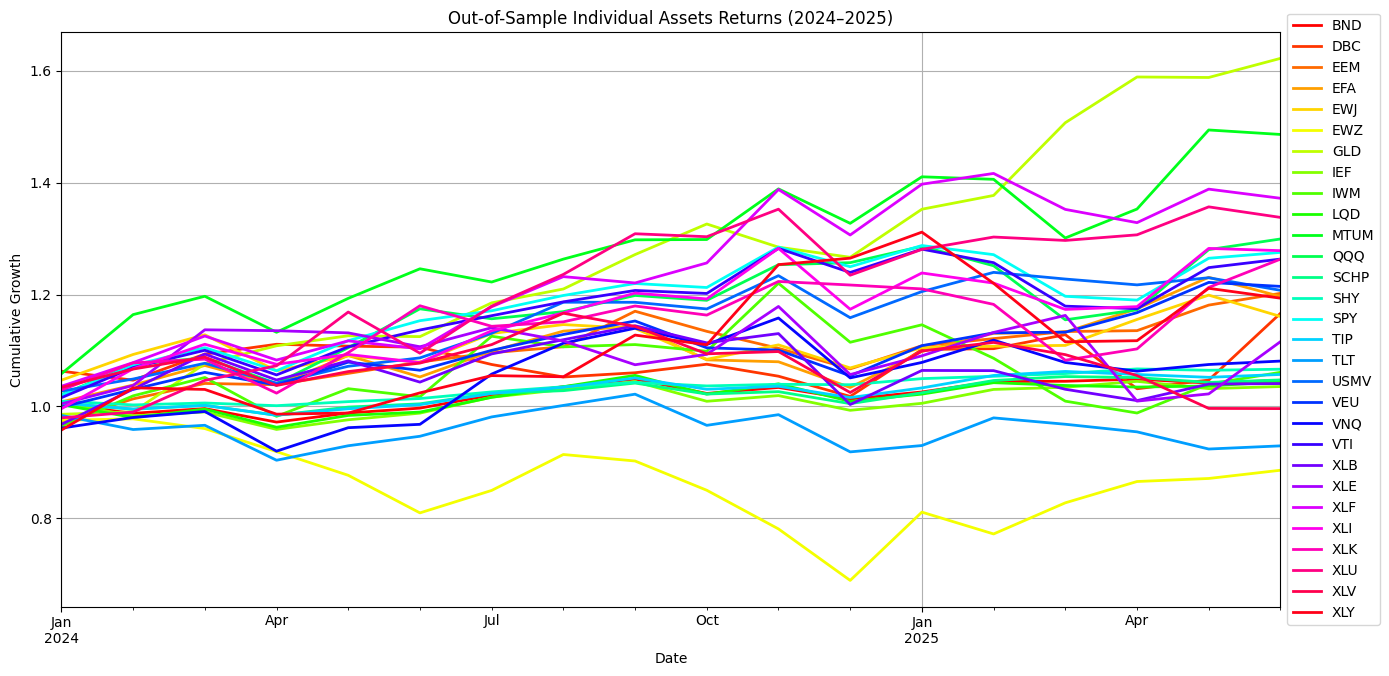

In [276]:
cumulative_asset_returns = (1 + returns_test).cumprod()

# Plot
plt.figure(figsize=(14, 7))
cumulative_asset_returns.plot(figsize=(14, 7), lw=2, colormap="hsv")
plt.title("Out-of-Sample Individual Assets Returns (2024–2025)")
plt.ylabel("Cumulative Growth")
plt.xlabel("Date")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


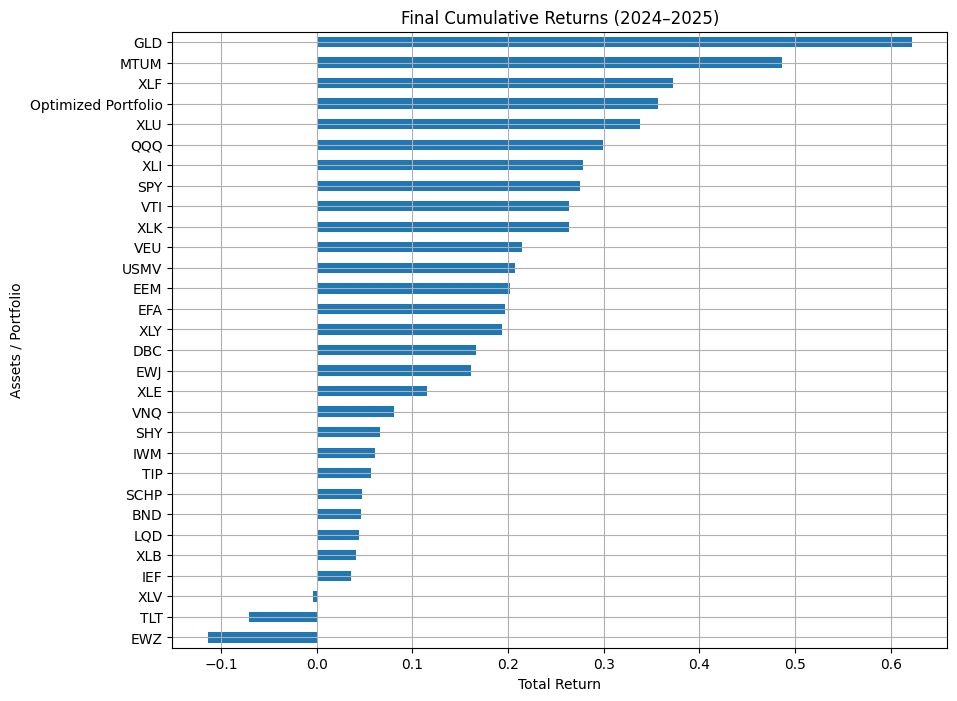

In [277]:
cumulative_asset_returns['Optimized Portfolio'] = cumulative_returns
final_returns = cumulative_asset_returns.iloc[-1] - 1
final_returns.sort_values(ascending=False).round(3)

final_returns.sort_values().plot(kind='barh', figsize=(10, 8), title="Final Cumulative Returns (2024–2025)")
plt.xlabel("Total Return")
plt.ylabel("Assets / Portfolio")
plt.grid(True)
plt.show()

## This Portfolio lands pretty high in terms up returns despite shorting constraints
With a shorting limit of 0.3, this portfolio was a spot higher with the same sharpe ratio.